In [1]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=False)
  base_dir = 'Colab_Notebooks/VisioneArtificiale/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  base_dir  =  '/Users/raffaella/GoogleDrive/Colab_Notebooks/VisioneArtificiale/'  #@param {type: "string"}

# dirs
wav_dir = 'data/wav/'
mp3_dir = 'data/mp3/'
img_dir = 'data/img/'
vid_dir = 'data/video/'
out_dir = 'output/'

# move to base_dir 
os.chdir(base_dir)
print("Current dir:", os.getcwd())

Mounted at /content/drive/
Current dir: /content/drive/MyDrive/Colab_Notebooks/VisioneArtificiale


In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt

In [3]:
imgL = cv2.imread(img_dir + 'book_left.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(img_dir + 'book_right.jpg', cv2.IMREAD_GRAYSCALE)

# Epipolar geometry
https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

- Find the keypoints and matches

In [4]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL,None)
kp2, des2 = sift.detectAndCompute(imgR,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

- Find the Fundamental matrix and verify the fundamental constraint:

In [5]:
# Now we have the list of best matches from both the images. Let's find the Fundamental Matrix.
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

N = pts1.shape[0]

p_im1_tilde = np.ones((3,N))
p_im1_tilde[0:2,:] = pts1.T

p_im2_tilde = np.ones ((3,N))
p_im2_tilde[0:2,:] = pts2.T

res = np.dot(np.dot(p_im1_tilde.T, F), p_im2_tilde)
print(res)


[[-0.06494729  0.30732148  0.30732148 ...  0.93296366  1.06689445
   1.06689445]
 [-1.06371389 -0.86899051 -0.86899051 ...  0.17197551  0.33311992
   0.33311992]
 [-1.06371389 -0.86899051 -0.86899051 ...  0.17197551  0.33311992
   0.33311992]
 ...
 [-1.00675724 -0.33718103 -0.33718103 ...  1.40493634  1.72455159
   1.72455159]
 [-1.15997187 -0.53001512 -0.53001512 ...  1.25650028  1.57602618
   1.57602618]
 [-1.15997187 -0.53001512 -0.53001512 ...  1.25650028  1.57602618
   1.57602618]]


- Find epilines

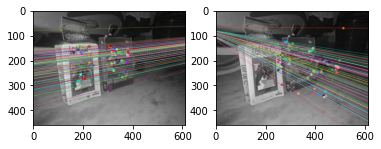

In [6]:
# Next we find the epilines. 
# Epilines corresponding to the points in first image is drawn on second image. 
# So mentioning of correct images are important here. We get an array of lines. 
# So we define a new function to draw these lines on the images.
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(imgL,imgR,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(imgL,imgR,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()   

# DEPTH MAP

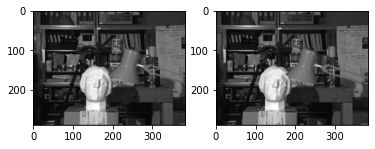

In [7]:
imgL = cv2.imread(img_dir + 'tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(img_dir + 'tsukuba_r.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(121),plt.imshow(imgL, cmap="gray")
plt.subplot(122),plt.imshow(imgR, cmap="gray")

rows, cols = imgL.shape

- Let's try to find a single match "by hand"

In [8]:
xl = 260
scanline = 120

C = np.zeros(cols)
SSD = np.zeros(cols)
SAD = np.zeros(cols)

w=15
lwin = imgL[scanline-w : scanline+w , xl-w : xl+w]     # Left template

In [9]:
for i in range(cols-2*w): #w+1 : cols-w 
    rwin = imgL[scanline-w : scanline+w ,  i :  i+2*w]# Right window
    C[i+w] = np.sum((lwin[:]-np.mean(lwin[:])) * (rwin[:]-np.mean(rwin[:]))) / (np.linalg.norm(lwin[:])*np.linalg.norm(rwin[:]))
    SSD[i+w] =  np.sum((lwin[:] - rwin[:])**2)
    SAD[i+w] = np.sum(np.abs(lwin[:] - rwin[:]))


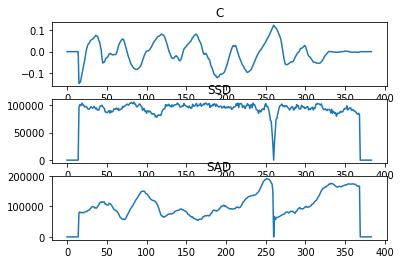

In [10]:
plt.subplot(3,1,1)
plt.plot(C)
plt.title("C")

plt.subplot(3,1,2)
plt.plot(SSD)
plt.title("SSD")

plt.subplot(3,1,3)
plt.plot(SAD)
plt.title("SAD")

minSAD = np.argmin(SAD[w+1: cols-w])

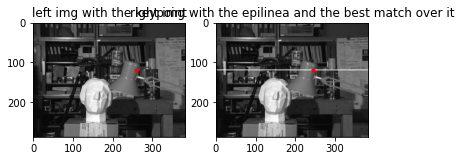

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imgL, cmap= "gray")
plt.scatter(xl, scanline, s=10, c='red', marker='o')
plt.title("left img with the keypoint")

imgR [scanline-1:scanline+1,:] =255
plt.subplot(1,2,2)
plt.imshow(imgR, cmap= "gray")
plt.scatter(minSAD, scanline, s=10, c='red', marker='o')
plt.title("right img with the epilinea and the best match over it")

plt.show()

- Now, let's use the `StereoBM_create` Class for computing stereo correspondence using the block matching algorithm

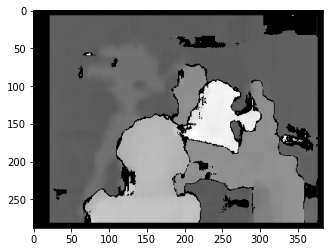

In [12]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()